In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [4]:
benign_train   =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/train/Benign',224))
insitu_train   =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/train/InSitu',224))
invasive_train =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/train/Invasive',224))
normal_train   =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/train/Normal',224))

benign_test    =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/test/Benign',224))
insitu_test    =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/test/InSitu',224))
invasive_test  =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/test/Invasive',224))
normal_test    =   np.array(Dataset_loader('/content/drive/My Drive/ICIAR2018-2/test/Normal',224))

100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


In [5]:
# Create labels
benign_train_label   = np.full(len(benign_train),0)
insitu_train_label   = np.full(len(insitu_train),1)
invasive_train_label = np.full(len(invasive_train),2)
normal_train_label   = np.full(len(normal_train),3)

benign_test_label   = np.full(len(benign_test),0)
insitu_test_label   = np.full(len(insitu_test),1)
invasive_test_label = np.full(len(invasive_test),2)
normal_test_label   = np.full(len(normal_test),3)

In [6]:
# Merge data 
X_train = np.concatenate((benign_train, insitu_train, invasive_train, normal_train), axis = 0)
Y_train = np.concatenate((benign_train_label, insitu_train_label, invasive_train_label, normal_train_label), axis = 0)
X_test = np.concatenate((benign_test, insitu_test, invasive_test, normal_test), axis = 0)
Y_test = np.concatenate((benign_test_label, insitu_test_label, invasive_test_label, normal_test_label), axis = 0)


In [7]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [8]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 4)
Y_test = to_categorical(Y_test, num_classes= 4)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [10]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [11]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)
 
dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
#nas      = NASNetMobile(include_top=False, input_shape=input_shape)(inputs)
#vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

74842112/74836368 [==============================] - 0s 0us/step


In [12]:
outputs = GlobalAveragePooling2D()(dennet)
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs) 
outputs = Dense(128,activation='relu')(outputs) 
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs) 
outputs = Dense(4, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 128)               245888    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [13]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/best_IARCR2_DesNet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [14]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=200,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
9/9 [==============================] - 8s 897ms/step - loss: 1.8127 - accuracy: 0.2639 - val_loss: 1.3725 - val_accuracy: 0.4444
Epoch 2/200
9/9 [==============================] - 5s 533ms/step - loss: 1.4087 - accuracy: 0.4688 - val_loss: 1.2094 - val_accuracy: 0.5556
Epoch 3/200
9/9 [==============================] - 5s 537ms/step - loss: 1.3214 - accuracy: 0.4306 - val_loss: 1.1222 - val_accuracy: 0.5833
Epoch 4/200
9/9 [==============================] - 5s 534ms/step - loss: 1.3965 - accuracy: 0.4583 - val_loss: 1.0430 - val_accuracy: 0.5694
Epoch 5/200
9/9 [==============================] - 5s 530ms/step - loss: 1.3009 - accuracy: 0.4965 - val_loss: 1.0096 - val_accuracy: 0.5694
Epoch 6/200
9/9 [==============================] - 5s 530ms/step - loss: 1.2086 - accuracy: 0.5556 - val_loss: 1.0378 - val_accuracy: 0.5694
Epoch 7/200
9/9 [==============================] - 5s 525ms/step - loss: 1.116

In [15]:
Y_pred = model.predict(X_test)

Confusion matrix, without normalization
[[10  0  0  0]
 [ 0  8  1  1]
 [ 1  0  9  0]
 [ 1  0  1  8]]


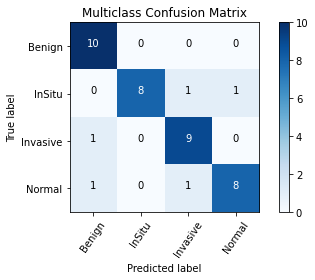

In [16]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Benign', 'InSitu', 'Invasive', 'Normal']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

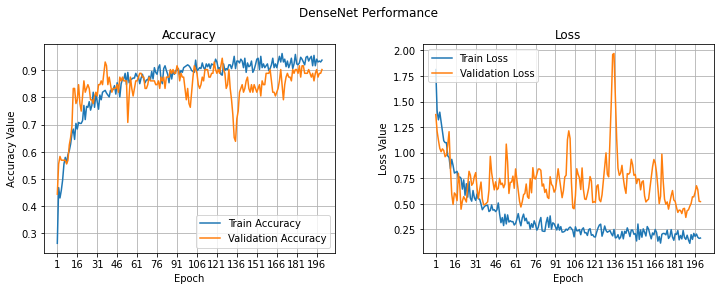

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('DenseNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,201))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 201, 15))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 201, 15))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [18]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Benign', 'InSitu', 'Invasive', 'Normal']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      Benign       0.83      1.00      0.91        10
      InSitu       1.00      0.80      0.89        10
    Invasive       0.82      0.90      0.86        10
      Normal       0.89      0.80      0.84        10

    accuracy                           0.88        40
   macro avg       0.89      0.88      0.87        40
weighted avg       0.89      0.88      0.87        40



In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

In [20]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=2)
auc=metrics.auc(fpr, tpr)
auc


0.6183333333333333

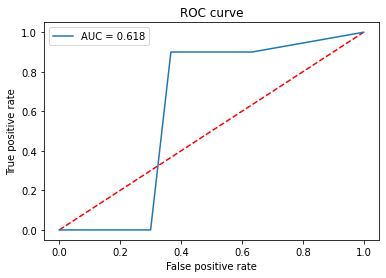

In [21]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()